# Tortuosity Analysis

In [5]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

#Home made functions
import Utilities #Does not work....

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -1 #Maximal number of cores in use
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/PDM/data/' #On laptop
FDIR = '../report/Figures/'
CASE = 'Bentheimer1000'
#####Reference values and ranges for filename generation#####
UREF = 4.6E-06
TREF = 2.92E+01
def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_d(v) :
    return '%.2f' % v
    
def v_to_pow(v) :
    if v == 0 :
        return r'$\infty$'
    else :
        power  = int(np.log10(v))
        factor = int(v/10.0**power)
        if factor == 1.0 :
            return r'$10^{'+str(power)+'}$'
        else :
            return str(factor)+r'$\times 10^{'+str(power)+'}$'

def print_keys(dict_) :
    for key in dict_ : print(key)
    return

In [6]:
def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

def ssl_transform(t) :
    N = len(t)
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
    return t_ssl

In [7]:
DATA = {}

SAMPLE = 'Bentheimer 1000'
PECLET = [0, 1e3, 1e2, 1e1, 1e0, 1e-1]
SLSM   = [20000, 20000, 20000, 20000, 20000, 20000]
CSF    = [1, 1, 1, 1, 1, 1]
KEYS   = []
for (Pe_, slsm_, csf_) in zip(PECLET, SLSM, CSF) : 
    name_ = DIR+CASE+'/Particle_Tracking/sl_out_Pe'+v_to_s(Pe_)+'_SLSM'+v_to_s(slsm_)+'_TMAX0_CSF'+str(csf_)+'.dat'
    key_  = 'Pe='+v_to_pow(Pe_)+', SLSM='+v_to_pow(slsm_)+', CSF='+str(csf_)
    DATA[key_] = name_
    KEYS.append(key_)

PLOT_KEYS = KEYS

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))

PARAM = {}
param = ['Pe','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key], param)
    
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + ' :')
        print('\t' + DATA[key])
        print('not found')

Dataset to load : 6


#### Computing traveled distances

In [8]:
UREF = 1.0
REDUCE = False; Nskip = 100
if REDUCE : str1 = '_reduced'
else : str1 = ''
dDNS = {}; dfname = DIR+'Processed_data/dDNS'+str1+'.dat' #Total traveled distance
dxDNS= {}; dxfname= DIR+'Processed_data/dxDNS'+str1+'.dat'#X-direction traveled distance
dyDNS= {}; dyfname= DIR+'Processed_data/dyDNS'+str1+'.dat'#Y-direction traveled distance
dzDNS= {}; dzfname= DIR+'Processed_data/dzDNS'+str1+'.dat'#Z-direction traveled distance
t_ssl = {}; tfname = DIR+'Processed_data/t_ssl'+str1+'.dat'

print('Loading data..')
if os.path.isfile(dfname) : 
    print('\tdDNS..')
    dDNS  = Load_data(dfname)
if os.path.isfile(dxfname): 
    print('\t dxDNS..')
    dxDNS = Load_data(dxfname)
if os.path.isfile(dyfname): 
    print('\tdyDNS')
    dyDNS = Load_data(dyfname)
if os.path.isfile(dzfname): 
    print('\tdzDNS')
    dzDNS = Load_data(dzfname)
if os.path.isfile(tfname) : 
    print('\tt_sslDNS')
    t_ssl = Load_data(tfname)
    
RERUN  = False
RESAVE = False
print('Checking if new data file...')
for key in DATA :
    if (key not in dDNS) or (key not in dyDNS) or (key not in t_ssl) or (RERUN) :
        RESAVE = True
        print("missing " + key + " data..")
        with open(DATA[key], 'r') as f:
            lines   = (line for line in f if (len(line)>100 and len(line)<150))
            print('\treading DNS data..')
            dataDNS = np.loadtxt(lines)
        del lines
        if REDUCE :
            print(len(dataDNS[:,0]))
            RANGE = range(0,len(dataDNS[:,0]),Nskip)
            dataDNS_reduced = np.zeros((len(RANGE),10))
            for i in range(10) :
                dataDNS_reduced[:,i]=dataDNS[RANGE,i]
            dataDNS = dataDNS_reduced
            del dataDNS_reduced
        print('\tprocessing data..')
        T_ = dataDNS[:,0]
        d_ = 0; dx_ = 0; dy_ = 0; dz_ = 0
        D_ = np.zeros(len(T_)); 
        DX_ = np.zeros(len(T_)); DY_ = np.zeros(len(T_)); DZ_ = np.zeros(len(T_))
        for i in range(len(T_)-1):
            dt_ = T_[i+1] - T_[i]
            if dt_ > 0 :
                d_ += np.sqrt(dataDNS[i,4]**2+dataDNS[i,5]**2+dataDNS[i,6]**2)/UREF  * dt_
                dx_+= dataDNS[i,4] * dt_
                dy_+= dataDNS[i,5] * dt_
                dz_+= dataDNS[i,6] * dt_
            D_[i]  = d_; DX_[i] = dx_; DY_[i] = dy_; DZ_[i] = dz_;
        dDNS[key]  = D_
        dxDNS[key] = DX_; dyDNS[key] = DY_; dzDNS[key] = DZ_
        t_ssl[key] = ssl_transform(T_)
        print('\tmean d = '+str(np.mean(dDNS[key])))
        del dataDNS, T_, D_, DX_, DY_, DZ_
if RESAVE :
    print('Saving...')
    Save_data(dDNS,dfname)
    Save_data(dxDNS,dxfname)
    Save_data(dyDNS,dyfname)
    Save_data(dzDNS,dzfname)
    Save_data(t_ssl,tfname)
    print('Done.')
else : print('Done.')

Loading data..
Checking if new data file...
missing Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1 data..
	reading DNS data..
	processing data..
	mean d = 376647.6676833136
missing Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1 data..
	reading DNS data..
	processing data..
	mean d = 346057.9908294063
missing Pe=$10^{2}$, SLSM=2$\times 10^{4}$, CSF=1 data..
	reading DNS data..
	processing data..
	mean d = 274664.3898692225
missing Pe=$10^{1}$, SLSM=2$\times 10^{4}$, CSF=1 data..
	reading DNS data..
	processing data..
	mean d = 78930.6255124166
missing Pe=$10^{0}$, SLSM=2$\times 10^{4}$, CSF=1 data..
	reading DNS data..
	processing data..
	mean d = 8566.301745855017
missing Pe=$10^{-1}$, SLSM=2$\times 10^{4}$, CSF=1 data..
	reading DNS data..
	processing data..
	mean d = 864.2979859336494
Saving...
Done.


#### Rough comparison of travelled distances

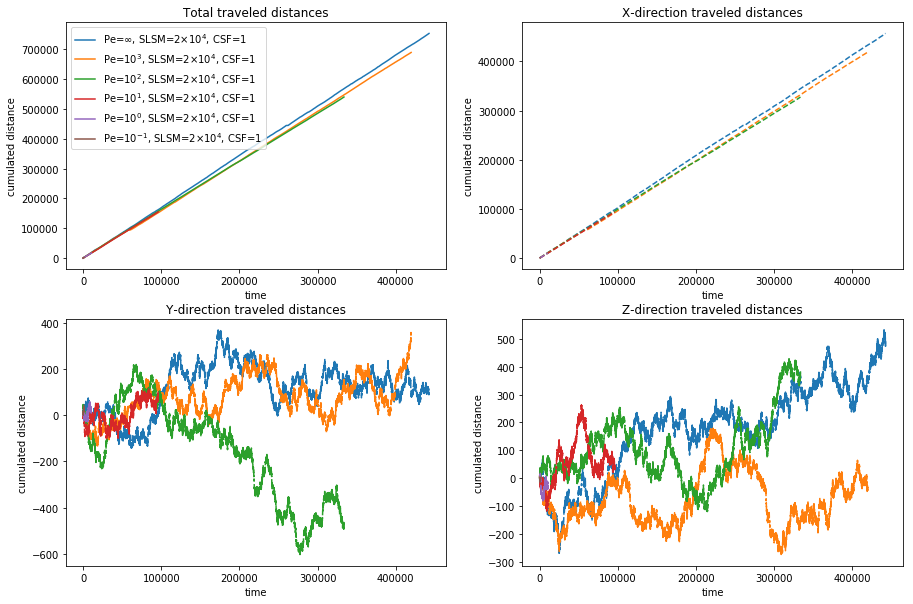

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
Nskip = 1000
N_ssl = {}
for key in PLOT_KEYS : N_ssl[key] = len(t_ssl[key])
(i,j) = (0,0)
axs[i,j].set_title('Total traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dDNS[key][range(0,N_ssl[key],Nskip)], '-', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')
axs[i,j].legend()

(i,j) = (0,1)
axs[i,j].set_title('X-direction traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dxDNS[key][range(0,N_ssl[key],Nskip)], '--', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,0)
axs[i,j].set_title('Y-direction traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dyDNS[key][range(0,N_ssl[key],Nskip)], '--', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,1)
axs[i,j].set_title('Z-direction traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dzDNS[key][range(0,N_ssl[key],Nskip)], '--', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

plt.savefig(FDIR+'traveled_distances.pdf')
plt.savefig(FDIR+'traveled_distances.png')

#### Same time comparison 

In [11]:
TMAX = []
for key in KEYS :
    TMAX.append(t_ssl[key][-1])
TMAXmin = min(TMAX)
Tcomp = {}; Ncomp = {};
for key in KEYS : 
    Tcomp[key] = [t_ for t_ in t_ssl[key] if t_ <= TMAXmin]
    Ncomp[key] = len(Tcomp[key])
    print(key + '\t: Tmax = '+str(t_ssl[key][-1])+',\t Ncomp = '+str(Ncomp[key])+',\t len Tcomp = '+str(len(Tcomp[key])))

Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1	: Tmax = 442473.8229187791,	 Ncomp = 143702,	 len Tcomp = 143702
Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1	: Tmax = 419633.86673578044,	 Ncomp = 151739,	 len Tcomp = 151739
Pe=$10^{2}$, SLSM=2$\times 10^{4}$, CSF=1	: Tmax = 333671.86862955015,	 Ncomp = 210416,	 len Tcomp = 210416
Pe=$10^{1}$, SLSM=2$\times 10^{4}$, CSF=1	: Tmax = 96114.85715581683,	 Ncomp = 644197,	 len Tcomp = 644197
Pe=$10^{0}$, SLSM=2$\times 10^{4}$, CSF=1	: Tmax = 10532.218666494842,	 Ncomp = 5877227,	 len Tcomp = 5877227
Pe=$10^{-1}$, SLSM=2$\times 10^{4}$, CSF=1	: Tmax = 1052.9494612367134,	 Ncomp = 56219053,	 len Tcomp = 56219053


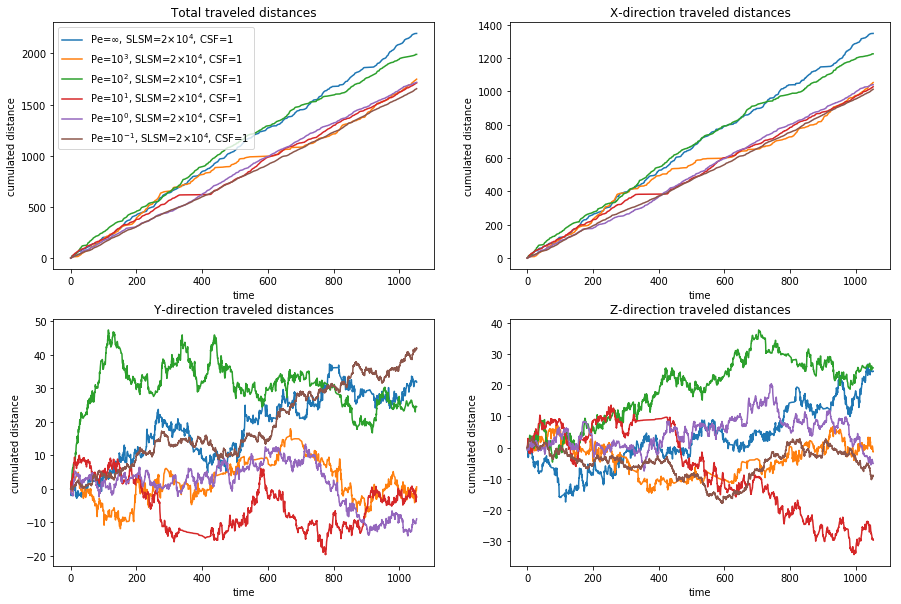

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
Nskip = 1000
(i,j) = (0,0)
axs[i,j].set_title('Total traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(Tcomp[key],dDNS[key][:Ncomp[key]], '-', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')
axs[i,j].legend()

(i,j) = (0,1)
axs[i,j].set_title('X-direction traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(Tcomp[key],dxDNS[key][:Ncomp[key]], '-', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,0)
axs[i,j].set_title('Y-direction traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(Tcomp[key],dyDNS[key][:Ncomp[key]], '-', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,1)
axs[i,j].set_title('Z-direction traveled distances')
for key in PLOT_KEYS : axs[i,j].plot(Tcomp[key],dzDNS[key][:Ncomp[key]], '-', label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

plt.savefig(FDIR+'traveled_distances_same_time.pdf')
plt.savefig(FDIR+'traveled_distances_same_time.png')

#### Computing tortuosity

In [13]:
N0     = 10000
Nskip  = 50
KAPPA = {}
for key in KEYS :
    Nmax = len(dDNS[key])
    Set    = range(N0,Nmax,Nskip)
    KAPPA[key] = [d_/dx_ for (d_,dx_) in zip(dDNS[key][Set],dxDNS[key][Set]) if dx_ != 0]
kmean = []; kstd = []; kend = [];
for key in KEYS :
    kmean.append(np.mean(KAPPA[key]))
    kstd.append(np.std(KAPPA[key]))
    kend.append(KAPPA[key][-1])
Kallmean = np.mean(kmean); Kallstd = np.std(kmean)

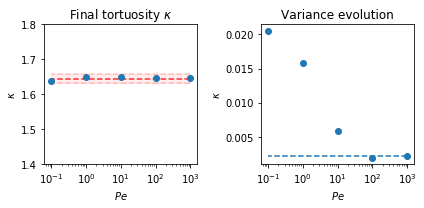

In [27]:
DM = [PARAM[key]['Pe'] for key in KEYS]
KMEAN=np.array([Kallmean for dm_ in DM])
KPSTD=np.array([Kallmean+np.abs(Kallstd) for dm_ in DM])
KMSTD=np.array([Kallmean-np.abs(Kallstd) for dm_ in DM])
fig, axs = plt.subplots(1,2,figsize=(6,3))

ax = axs[0]
ax.set_title(r'Final tortuosity $\kappa$');
ax.fill_between(DM,KMSTD, KPSTD, color='r', alpha=0.08) 
ax.plot(DM,KMEAN,'r--',alpha=0.8, label = 'Mean')
ax.plot(DM,KPSTD,'r--',alpha=0.2)
ax.plot(DM,KMSTD,'r--',alpha=0.2)
ax.plot(DM,kend,'o')
ax.set_xscale('log');
ax.set_xlabel(r'$Pe$');
ax.set_ylim([1.4,1.8])
ax.set_ylabel(r'$\kappa$');

ax = axs[1]
ax.set_title(r'Variance evolution');
ax.plot(DM,kstd,'o')
ax.plot(DM,[kstd[0] for d_ in DM],'--', color = color_cycle[0])
ax.set_xscale('log');
ax.set_xlabel(r'$Pe$');
ax.set_ylabel(r'$\kappa$');
plt.tight_layout()
plt.savefig(FDIR+'tortuosity.pdf')
plt.savefig(FDIR+'tortuosity.png')

In [ ]:
for key in PLOT_KEYS :
    plt.plot(KAPPA[key][100000:],label = key);
plt.legend(loc='upper center', bbox_to_anchor=(1.0, 1.0), shadow=True, ncol=1)